TO DO:
- Modify model to work for plotting volatility smiles and surfaces on SABR and shiftedSABR

In [108]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd

from pysabr import Hagan2002LognormalSABR
from scipy.optimize import minimize


import yfinance as yf
spx = yf.Ticker("^SPX")

current_price = spx.info["regularMarketPrice"]

df = pd.concat([spx.option_chain(x).calls for x in spx.options])
df['contractSymbol'] = dates_numeric = df['contractSymbol'].str.replace(r"[a-zA-Z]", '').map(lambda x: str(x)[:-8])
df['contractSymbol'] = pd.to_datetime(df['contractSymbol'], format='%y%m%d')

maturities = df['contractSymbol'].unique()
df.head(10)


C:\Users\somig\AppData\Local\Temp/ipykernel_18692/3431632298.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df['contractSymbol'] = dates_numeric = df['contractSymbol'].str.replace(r"[a-zA-Z]", '').map(lambda x: str(x)[:-8])


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,2021-08-04,2021-08-02 12:34:35,3600.0,814.55,796.8,805.4,0.0,0.0,13.0,0.0,1.743440,1.0,REGULAR,USD
1,2021-08-04,2021-07-29 13:45:29,3775.0,642.62,625.7,626.7,0.0,0.0,3.0,0.0,1.405154,1.0,REGULAR,USD
2,2021-08-04,2021-07-27 16:33:27,3900.0,483.56,500.7,501.8,0.0,0.0,2.0,0.0,1.164433,1.0,REGULAR,USD
3,2021-08-04,2021-07-19 13:48:58,4050.0,239.40,350.8,351.8,0.0,0.0,NaN,0.0,0.872957,1.0,REGULAR,USD
4,2021-08-04,2021-07-28 19:38:21,4055.0,352.10,345.8,346.8,0.0,0.0,NaN,0.0,0.863100,1.0,REGULAR,USD
5,2021-08-04,2021-07-20 16:00:09,4060.0,273.66,340.8,341.8,0.0,0.0,8.0,0.0,0.853212,1.0,REGULAR,USD
6,2021-08-04,2021-07-22 16:05:12,4080.0,278.10,320.8,321.8,0.0,0.0,1.0,0.0,0.813600,1.0,REGULAR,USD
7,2021-08-04,2021-07-20 20:02:33,4090.0,245.00,310.8,311.8,0.0,0.0,2.0,0.0,0.793703,1.0,REGULAR,USD
8,2021-08-04,2021-07-20 19:32:23,4110.0,235.50,290.8,291.8,0.0,0.0,2.0,0.0,0.753756,1.0,REGULAR,USD
9,2021-08-04,2021-07-20 19:18:29,4115.0,231.30,285.8,286.8,0.0,0.0,1.0,0.0,0.743716,1.0,REGULAR,USD


In [109]:
import time
import datetime

current_time = time.localtime()

def delta_t(m):

    now = pd.to_datetime(time.strftime('%Y-%m-%d %H:%M:%S', current_time))
    delta_t = m - now
    year_dt = datetime.timedelta(365,0,0,0)

    return round(delta_t/year_dt, 6)


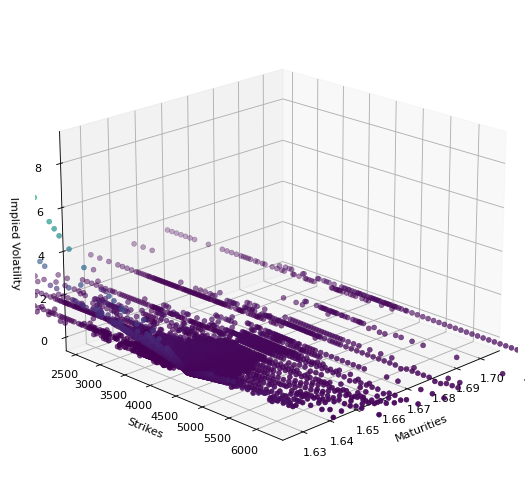

In [110]:
# 3d surface plot

polished_df = df[df["strike"] >= 3500]
polished_df = polished_df[polished_df["strike"] <= 5700]

x = pd.to_numeric(df["contractSymbol"])
y = df["strike"]
z = df["impliedVolatility"]


def plot3d(x, y, z, rng=current_price, scatter=True):
    fig = plt.figure(figsize=(15, 8), dpi=80)

    ax = plt.axes(projection='3d')
    if scatter:
        ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=.5)
    else:
        ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none');



    ax.set_xlabel('Maturities')
    ax.set_ylabel('Strikes')
    ax.set_zlabel('Implied Volatility')

    ax.set_ylim((current_price - rng, current_price + rng))
    
    ax.invert_xaxis()
    ax.view_init(20, 45)
    

    plt.show()

#2d volatility smiles

def plot2d(x, y):
    fig = plt.figure(figsize=(6, 4), dpi=80)
    ax = fig.gca()

    ax.plot(x, y)

    ax.set_xlabel('Strikes')
    ax.set_ylabel('Implied Volatility')
    ax.set_xbound(4000, 6000)

    plt.show()


plot3d(x, y, z, 2000)  

In [135]:
def SABR(alpha,beta,rho,nu,F,K,time,MKT):
    print(beta)
    if K <= 0:
        VOL = diff = 0
        print("K=0")
    elif F == K: # ATM formula
        V = (F*K)**((1-beta)/2.)
        logFK = math.log(F/K)
        A = 1 + ( ((1-beta)**2*alpha**2)/(24.*(V**2)) + (alpha*beta*nu*rho)/(4.*V) + ((nu**2)*(2-3*(rho**2))/24.) ) * time
        B = 1 + (1/24.)*(((1-beta)*logFK)**2) + (1/1920.)*(((1-beta)*logFK)**4)
        VOL = (alpha/V)*A
        diff = VOL - MKT
    elif F != K: # not-ATM formula
        V = (F*K)**((1-beta)/2.)
        logFK = math.log(F/K)
        z = (nu/alpha)*V*logFK
        print(1-2*rho*z+z**2); x = math.log( ( math.sqrt(1-2*rho*z+z**2) + z - rho ) / (1-rho) )
        A = 1 + ( ((1-beta)**2*alpha**2)/(24.*(V**2)) + (alpha*beta*nu*rho)/(4.*V) + ((nu**2)*(2-3*(rho**2))/24.) ) * time
        B = 1 + (1/24.)*(((1-beta)*logFK)**2) + (1/1920.)*(((1-beta)*logFK)**4)
        VOL = (nu*logFK*A)/(x*B)
        diff = VOL - MKT
    if MKT == 0:
       VOL = diff = 0

    return VOL


In [137]:
def shift(F,K):
    shift = 0.001 - K[0]
    for j in range(len(K)):
        K[j] = K[j] + shift
        F = F + shift
        
def smile(alpha,beta,rho,nu,F,K,time,MKT,i):
    print(beta)
    vol_vector = []

    for j in range(len(K)):
        #if K[0] <= 0:
        #    shift(F,K)
        vol_vector.append(SABR(alpha,beta,rho,nu,F,K[j],time,MKT[j]))
    
    return vol_vector
    
def SABR_vol_matrix(alpha,beta,rho,nu,F,K,time,MKT):
    print(beta)
    smile_vector = []

    for i in range(len(F)):
        smile_vector.append(smile(alpha[i],beta,rho[i],nu[i],F[i],K[i],time[i],MKT[i],i))
    
    return smile_vector

In [143]:
import math

def objfunc(par,F,K,time,MKT):
    beta = 1
    sum_sq_diff = 0
    if K[0]<=0:
        shift(F,K)
    for j in range(len(K)):
        if MKT[j] == 0:   
            diff = 0       
        elif F == K[j]: 
            V = (F*K[j])**((1-beta)/2.)
            logFK = math.log(F/K[j])
            A = 1 + ( ((1-beta)**2*par[0]**2)/(24.*(V**2)) + (par[0]*beta*par[2]*par[1])/(4.*V) + ((par[2]**2)*(2-3*(par[1]**2))/24.) ) * time
            B = 1 + (1/24.)*(((1-beta)*logFK)**2) + (1/1920.)*(((1-beta)*logFK)**4)
            VOL = (par[0]/V)*A
            diff = VOL - MKT[j]
        elif F != K[j]: 
            V = (F*K[j])**((1-beta)/2.)
            logFK = math.log(F/K[j])
            z = (par[2]/par[0])*V*logFK
            x = math.log( ( math.sqrt(1-2*par[1]*z+z**2) + z - par[1] ) / (1-par[1]) )
            A = 1 + ( ((1-beta)**2*par[0]**2)/(24.*(V**2)) + (par[0]*beta*par[2]*par[1])/(4.*V) + ((par[2]**2)*(2-3*(par[1]**2))/24.) ) * time
            B = 1 + (1/24.)*(((1-beta)*logFK)**2) + (1/1920.)*(((1-beta)*logFK)**4)
            VOL = (par[2]*logFK*A)/(x*B)
            diff = VOL - MKT[j]  
        sum_sq_diff = sum_sq_diff + diff**2  
        obj = math.sqrt(sum_sq_diff)
    return obj


def calibration(F,K,time,MKT):
    alpha = rho = nu = []

    for i in range(len(F)):
        
        x0 = [.5, .5, .5]
        bnds = ( (0.001,None), (-0.999,0.999), (0.001,None) )
        
        res = minimize(objfunc, x0 , (F[i], K[i], time[i], MKT[i]), bounds = bnds, method='SLSQP') # for a constrained minimization of multivariate scalar functions

        alpha.append(res.x[0])
        rho.append(res.x[1])
        nu.append(res.x[2])

    return (alpha, rho, nu)


In [145]:
K = []
MKT = []
t = []
F = [current_price] * len(maturities)
for m in maturities:
    option = df[df["contractSymbol"] == m]

    K.append(np.array(option["strike"]))
    MKT.append(np.array(option["impliedVolatility"]))
    t.append(np.array(delta_t(pd.to_datetime(m))))

(alpha, rho, nu) = calibration(F, K, t, MKT)

TypeError: con() missing 2 required positional arguments: 'F' and 'K'

In [144]:
sabr = SABR_vol_matrix(alpha, .5, rho, nu, F, K, t, MKT)

sabr

0.5
0.5
0.5
152.13472081193044
0.5
89.6250318737197
0.5
55.71445794182975
0.5
26.174985179108
0.5
25.39267381951859
0.5
24.623161644619255
0.5
21.67263916077647
0.5
20.27356955333722
0.5
17.62689480946047
0.5
16.99664826867606
0.5
16.37892525862257
0.5
15.773703227074279
0.5
15.180959685095042
0.5
14.600672206792966
0.5
14.032818429077725
0.5
13.477376051418275
0.5
12.934322835601385
0.5
12.4036366054927
0.5
11.885295246797508
0.5
11.379276706823621
0.5
10.885558994244942
0.5
10.404120178866359
0.5
9.934938391390205
0.5
9.47799182318274
0.5
9.033258726043082
0.5
8.600717411972317
0.5
8.180346252944279
0.5
7.77212368067701
0.5
7.376028186405863
0.5
6.992038320657004
0.5
6.620132693022909
0.5
6.2602899719378655
0.5
5.912488884455802
0.5
5.576708216027887
0.5
5.252926810282244
0.5
4.94112356880431
0.5
4.641277450918127
0.5
4.353367473468837
0.5
4.07737271060642
0.5
3.8132722935700416
0.5
3.5610454104737204
0.5
3.3206713060930424
0.5
3.0921292816527832
0.5
2.8753986946155066
0.5
2.67045895

ValueError: math domain error

In [7]:
######## set swaptions characteristics ###############################
     
strike_spreads=[]
j=0
while True:
    try:
        strike_spreads.append(int(Market_data.cell(1,3+j).value))
        j = j+1
    except:
        break
num_strikes = len(strike_spreads)

expiries=[]
i=0
while True:
        try:
            expiries.append(Market_data.cell(2+i,1).value)
            i = i + 1
        except:
            break

tenors=[]
i=0
while True:
    try:
        tenors.append(Market_data.cell(2+i,0).value)
        i = i + 1
    except:
        break


# to create the ATM forward rates
F = []
i=0
while True:
    try:
        F.append(Market_data.cell(2+i,2).value)
        i = i+1
    except:
        break

# to create the strike grid
K = np.zeros((len(F),num_strikes))
for i in range(len(F)):
    for j in range(num_strikes):
        K[i][j] = F[i] + 0.0001*(strike_spreads[j])  

# to create market volatilities            
MKT = np.zeros((len(F),num_strikes))
for i in range(len(F)):
    for j in range(num_strikes):
        MKT[i][j] = Market_data.cell(2+i,3+j).value


# set starting parameters
starting_guess = np.array([0.001,0.5,0,0.001])
alpha = len(F)*[starting_guess[0]]
beta = len(F)*[starting_guess[1]]
rho = len(F)*[starting_guess[2]]
nu = len(F)*[starting_guess[3]]


In [8]:
######## set labels ###################################################

exp_dates = len(expiries)*[0]
for i in range(len(expiries)):
    if expiries[i] < 1:
        exp_dates[i] = str(int(round(12*expiries[i])))+'m'
    else:
        exp_dates[i] = str(int(round(expiries[i])))+'y'
        if expiries[i]-round(expiries[i]) > 0:
            exp_dates[i] = exp_dates[i]+str(int(round((12*(round(expiries[i],2)-int(expiries[i]))))))+'m' 
        elif expiries[i]-round(expiries[i]) < 0:
            exp_dates[i] = str(int(round(tenors[i]))-1)+'y'
            exp_dates[i] = exp_dates[i]+str(int(round((12*(round(expiries[i],2)-int(expiries[i]))))))+'m'

ten_dates = len(tenors)*[0]
for i in range(len(tenors)):
    if tenors[i] < 1:
        ten_dates[i] = str(int(round(12*tenors[i])))+'m'
    else:
        ten_dates[i] = str(int(round(tenors[i])))+'y'
        if tenors[i]-round(tenors[i]) > 0:
            ten_dates[i] = ten_dates[i]+str(int(round((12*(round(tenors[i],2)-int(tenors[i]))))))+'m' 
        elif tenors[i]-round(tenors[i]) < 0:
            ten_dates[i] = str(int(round(tenors[i]))-1)+'y'
            ten_dates[i] = ten_dates[i]+str(int(round((12*(round(tenors[i],2)-int(tenors[i]))))))+'m'

label_exp = exp_dates
label_ten = ten_dates
label_strikes = num_strikes*[0]
for i in range(num_strikes):
    if strike_spreads[i] == 0 :
        label_strikes[i] = 'ATM'
    else:
        label_strikes[i] = str(strike_spreads[i])


In [9]:
######## Call the functions #################################

calibration(starting_guess,F,K,expiries,MKT)

SABR_vol_matrix(alpha,beta,rho,nu,F,K,expiries,MKT)

[]
